Movie Reviewer dataset
========================


In [16]:
# Loading required libraries
import pandas as pd
import networkx as nx
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.pyplot as plt
import random
from concurrent.futures import ThreadPoolExecutor
from itertools import combinations
from collections import defaultdict
import scipy.optimize as opt
from tqdm import tqdm
from scipy.sparse import csr_matrix, lil_matrix
from scipy.stats import hypergeom
import seaborn as sns

Loading the dataset

In [3]:
# Getting the reviewers and movies separated directly from the graph
reviewers = set()
movies = set()

with open("rec-movielens.edges") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:  # Since 3 columns in data: reviewer, movie, score
            reviewer, movie, _ = parts
            # Adding prefix to avoid self-loops: R for reviewers and M for movies
            reviewers.add(f"R_{reviewer}") 
            movies.add(f"M_{movie}")       

# Generating the graph
B = nx.Graph() 
with open("rec-movielens.edges") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:
            reviewer, movie, weight = parts
            B.add_edge(f"R_{reviewer}", f"M_{movie}", weight=float(weight))

# Assigning the bipartite attribute to our nodes
# 0 for reviewers
nx.set_node_attributes(B, {n: 0 for n in reviewers}, "bipartite")
# 1 for movies
nx.set_node_attributes(B, {n: 1 for n in movies}, "bipartite")

# Extracting the reviewers and movies from the graph using the bipartite attribute from above
reviewers = {n for n, d in B.nodes(data=True) if d.get("bipartite") == 0}
movies = {n for n, d in B.nodes(data=True) if d.get("bipartite") == 1}

# Printing the N of nodes
print(f"Number of reviewers: {len(reviewers)}")
print(f"Number of movies: {len(movies)}")

FileNotFoundError: [Errno 2] No such file or directory: 'rec-movielens.edges'

Checking the correctness by loading the data as a pandas dataframe and getting the N of reviewers and movies

In [4]:
# Loading the data as a dataframe
df = pd.read_csv("rec-movielens.edges", sep=" ", header=None, names=["reviewer", "movie", "weight"])

# Add prefixes to avoid self-loops
df["reviewer"] = "R_" + df["reviewer"].astype(str)
df["movie"] = "M_" + df["movie"].astype(str)

# Print the number of unique reviewers and movies
print("Number of reviewers:", df["reviewer"].nunique())
print("Number of movies:", df["movie"].nunique())

Number of reviewers: 69878
Number of movies: 10677


The number of reviewers and movies match in both a graph and a dataframe

Visualiztion of the original dataset(a sample)

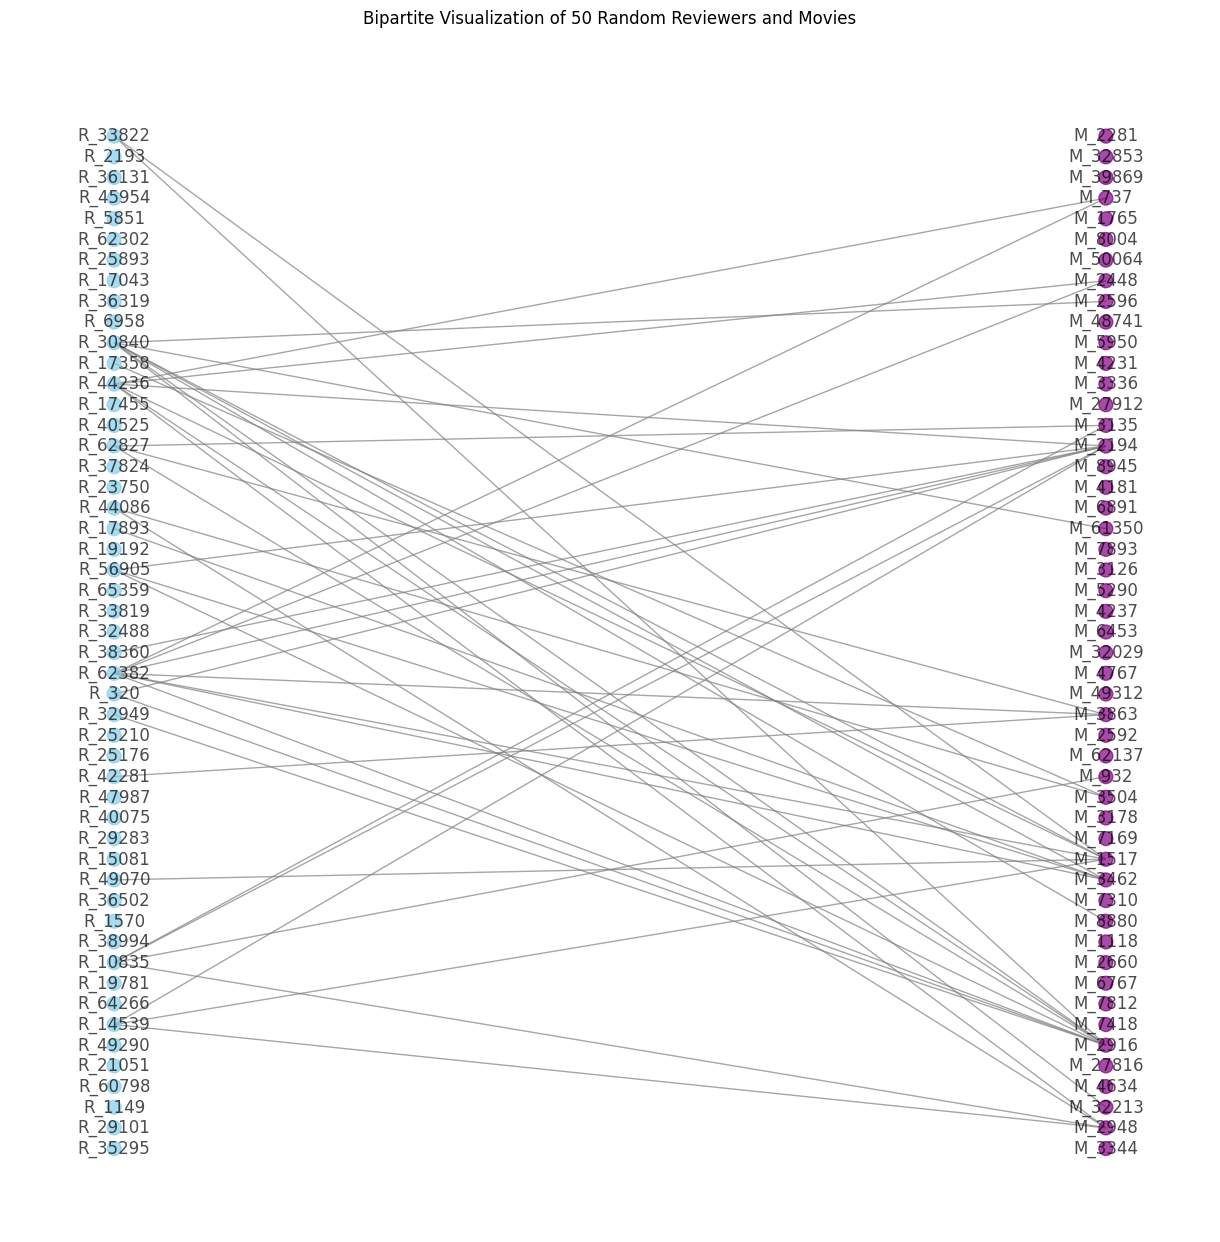

In [5]:
random.seed(33)
# Selecting 50 random reviewers and movies
reviewer_nodes = random.sample(list(reviewers), 50)
movie_nodes = random.sample(list(movies), 50)
selected_nodes = reviewer_nodes + movie_nodes

# Extracting a subgraph with the nodes
subgraph = B.subgraph(selected_nodes)

# Plotting a bipartite graph
plt.figure(figsize=(12, 12))
pos = nx.bipartite_layout(subgraph, nodes=reviewer_nodes)
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=100,
    node_color=["skyblue" if n in reviewers else "purple" for n in subgraph.nodes()],
    edge_color="gray",
    alpha=0.7
)
plt.title("Bipartite Visualization of 50 Random Reviewers and Movies")
plt.show()

In [6]:
# Checking reviewers by number of movies reviewed
reviewer_counts = df.groupby("reviewer")["movie"].count()
reviewer_counts.name = "review_count"

# Sort by review_count in descending order
reviewer_counts = reviewer_counts.sort_values(ascending=False)
# Reset the index
reviewer_counts = reviewer_counts.reset_index()
reviewer_counts

,reviewer,review_count
0,R_59269,7359
1,R_67385,7047
2,R_14463,5169
3,R_68259,4483
4,R_27468,4449
...,...,...
69873,R_59985,20
69874,R_55854,20
69875,R_12131,20
69876,R_52415,20


Stratified sampling
========================

In [ ]:
# Params
keep = 0.1  # 10% reviewers
max_bin = 7  # max bins

# Review counts
reviewer_counts = df.groupby("reviewer")["movie"].count()
reviewer_counts.name = "count"
total_reviewers = len(reviewer_counts)
target_size = int(keep * total_reviewers)

print(f"Reviewers: {total_reviewers}, Target: {target_size}")

# Binning
bins = min(max_bin, reviewer_counts.nunique())
print(f"Bins: {bins}")
strata_labels = [f"Bin_{i+1}" for i in range(bins)]
strata = pd.qcut(reviewer_counts, q=bins, labels=strata_labels, duplicates="drop")

# Sampling
sampled_reviewers = []
stratum_sizes = strata.value_counts().sort_index()
print(f"Stratum sizes:\n{stratum_sizes}")

# Set a fixed random seed for reproducibility
random_seed = 33

for label in strata_labels:
    reviewers_bin = reviewer_counts[strata == label]
    if len(reviewers_bin) == 0:
        continue
    n_sample = int(len(reviewers_bin) / total_reviewers * target_size)
    n_sample = min(n_sample, len(reviewers_bin))
    sampled = reviewers_bin.sample(n=n_sample, random_state=random_seed).index.tolist()
    sampled_reviewers.extend(sampled)

print(f"Sampled reviewers: {len(sampled_reviewers)}")

# Filter data
if df["reviewer"].dtype != pd.Series(sampled_reviewers).dtype:
    sampled_reviewers = [str(r) for r in sampled_reviewers]
    df["reviewer"] = df["reviewer"].astype(str)

df_sample = df[df["reviewer"].isin(sampled_reviewers)]
print(f"Filtered rows: {len(df_sample)}, Reviewers: {df_sample['reviewer'].nunique()}")

# Saving the sampled data
df_sample.to_csv("sampled_reviewers.csv", index=False, sep=" ", header=False)

Reviewers: 69878, Target: 6987
Bins: 7
Stratum sizes:
count
Bin_1    10341
Bin_2    10001
Bin_3    10035
Bin_4     9728
Bin_5     9870
Bin_6     9967
Bin_7     9936
Name: count, dtype: int64
Sampled reviewers: 6982
Filtered rows: 994563, Reviewers: 6982


Filtering edges: 100%|██████████| 44085884/44085884 [1:46:17<00:00, 6912.27it/s]  


Graph has 6982 nodes and 19118275 edges


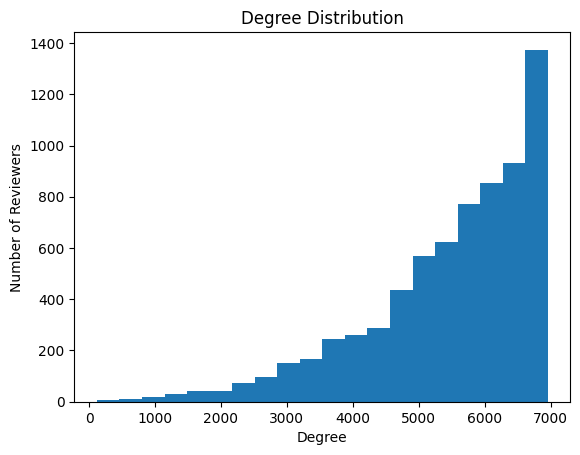

Avg degree: 5476.45
Connected components: 1


In [9]:
# Create bipartite matrix from df_sample
reviewers = df_sample['reviewer'].astype('category')
movies = df_sample['movie'].astype('category')

row = reviewers.cat.codes.values
col = movies.cat.codes.values
data = np.ones(len(df_sample))

B = csr_matrix((data, (row, col)), shape=(len(reviewers.cat.categories), len(movies.cat.categories)))
reviewer_map = dict(enumerate(reviewers.cat.categories))

# Compute co-occurrence matrix
def compute_cooccurrence_matrix(B, chunk_size=1000):
    n_reviewers = B.shape[0]
    cooccurrence = lil_matrix((n_reviewers, n_reviewers))
    for start in tqdm(range(0, n_reviewers, chunk_size), desc="Computing Co-occurrence"):
        end = min(start + chunk_size, n_reviewers)
        batch = B[start:end, :]
        cooccurrence[start:end, :] = batch @ B.T
    return cooccurrence.tocsr()

C = compute_cooccurrence_matrix(B)

# Filter edges using hypergeometric test
def filter_edges(B, C, alpha=0.05):
    N_movies = B.shape[1]
    degrees = B.sum(axis=1).A1
    rows, cols = C.nonzero()
    data = []
    for i, j in tqdm(zip(rows, cols), total=len(rows), desc="Filtering edges"):
        if i >= j:
            continue
        k = C[i, j]
        pval = hypergeom.sf(k - 1, N_movies, degrees[i], degrees[j])
        if pval < alpha:
            data.append((i, j, k))
    return data

edges = filter_edges(B, C)

# Analyze network
G = nx.Graph()
for i, j, w in edges:
    G.add_edge(reviewer_map[i], reviewer_map[j], weight=w)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Visualize degree distribution
degree_vals = [deg for _, deg in G.degree()]
plt.hist(degree_vals, bins=20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Reviewers")
plt.show()

# Print basic metrics
print(f"Avg degree: {np.mean(degree_vals):.2f}")
print(f"Connected components: {nx.number_connected_components(G)}")


In [10]:
# Save the resulting graph to an edges file
output_file = "final_graph.edges"
nx.write_edgelist(G, output_file, data=["weight"])

print(f"Graph saved to {output_file}")

Graph saved to final_graph.edges


In [2]:
#Loading the graph from the edges file, generated before

# Load the graph from the edge list file
input_file = "final_graph.edges"
G = nx.read_edgelist(
    input_file, 
    nodetype=str,  # Ensure nodes are read as strings
    data=(("weight", float),)  # Ensure the "weight" attribute is read as a float
)

# Verify the graph
print(f"Loaded graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Loaded graph has 6982 nodes and 19118275 edges.


In [ ]:
# Compute average degree for the bipartite graph
degrees = [deg for _, deg in hasattr.degree()]
avg_degree_H = np.mean(degrees)
print(f"Avg degree of P: {avg_degree_H:.2f}")

# Compute the number of connected components
connected_components_H = nx.number_connected_components(H)
print(f"Connected components in H: {connected_components_H}")

Avg degree of B: 248.28
Connected components in B: 1


Loading the sample

In [ ]:
df_sample = pd.read_csv('sampled_reviewers.csv', sep=' ', header=None, names=['reviewer', 'movie', 'weight'])
df_sample

,reviewer,movie,weight
0,R_3,M_110,4.5
1,R_3,M_151,4.5
2,R_3,M_213,5.0
3,R_3,M_590,3.5
4,R_3,M_1148,4.0
...,...,...,...
994558,R_71557,M_593,4.0
994559,R_71557,M_595,4.0
994560,R_71557,M_596,4.0
994561,R_71557,M_608,5.0


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original distribution
sns.histplot(reviewer_counts, log_scale=True, kde=True, ax=axes[0])
axes[0].set_title("Original Review Counts")
axes[0].set_xlabel("Review Counts")
axes[0].set_ylabel("Frequency")

# Sampled distribution
sns.histplot(df_sample.groupby("reviewer")["movie"].count(), log_scale=True, kde=True, ax=axes[1])
axes[1].set_title("Sampled Review Counts")
axes[1].set_xlabel("Review Counts")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()